# Drought Prediction in the Mediterranean

In [186]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, plot_confusion_matrix
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [6]:
# # Train/Test Split - Just run once
# X_tas = np.load('Data/tas_train.npy')
# X_psl = np.load('Data/psl_train.npy')
# y=np.load('Data/nao_index_train.npy')

# X = np.concatenate((X_tas, X_psl),axis=1)
# y=y.reshape(-1,1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# np.save('Data/train/X_train.npy', X_train)
# np.save('Data/test/X_test.npy', X_test)
# np.save('Data/train/y_train.npy', y_train)
# np.save('Data/test/y_test.npy', y_test)

# Exploratory Data Analysis

In [176]:
#Load training data
X_train = np.load('Data/train/X_train.npy')
y_train = np.load('Data/train/y_train.npy')
print(X_train.shape)
print(y_train.shape)

(720, 4644)
(720, 1)


In [155]:
# Data are standardized by column
X_df = pd.DataFrame(X_train)
print("Range of means: ",X_df.mean().max() - X_df.mean().min())
print("Range of stdevs: ",X_df.std().max() - X_df.std().min())

Range of means:  0.10698490791697654
Range of stdevs:  0.09475504033032955


In [156]:
# No missing data (synthetic dataset, so none are expected)
X_df.isna().sum().sum()

0

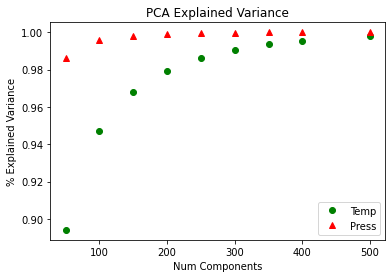

In [157]:
# PCA - Virtually all variance is explained in the first 200 PCs of press and the first 500 PCs of temp
num_components = [50,100,150,200,250,300,350,400,500]
explained_variance_temp = []
explained_variance_press = []
for i in num_components:
    pca_temp = PCA(n_components=i)
    pca_press = PCA(n_components=i)
    X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
    X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
    explained_variance_temp.append(pca_temp.explained_variance_ratio_.sum())
    explained_variance_press.append(pca_press.explained_variance_ratio_.sum())

    
plt.plot(num_components,explained_variance_temp,'go',label="Temp")
plt.plot(num_components,explained_variance_press,"r^",label="Press")
plt.title("PCA Explained Variance")
plt.xlabel("Num Components")
plt.ylabel("% Explained Variance")
plt.legend(loc="lower right")
plt.show()


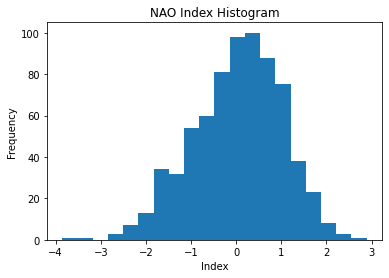

In [158]:
np.histogram(y_train, bins=20);
plt.title("NAO Index Histogram")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.hist(y_train,bins=20)
plt.show()

#### Investigate Correlation between target variable and each coordinate

In [174]:
data = pd.DataFrame(X_train)

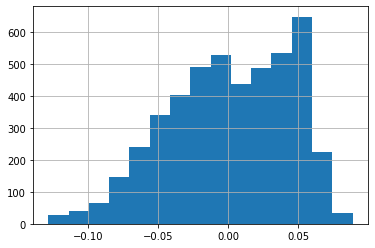

In [178]:
data.corrwith(pd.Series(y_train.reshape(720,))).hist(bins=15);

# Preprocessing

In [159]:
# Transform Training Data with PCA
pca_temp = PCA(n_components=500)
pca_press = PCA(n_components=200)
X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
X_train_pca = np.concatenate((X_tas_pca,X_psl_pca),axis=1)

In [160]:
# Calculate reconstruction error
X_tas_projected = pca_temp.inverse_transform(X_tas_pca)
X_psl_projected = pca_press.inverse_transform(X_psl_pca)
loss_temp = ((X_train[:,0:2322]-X_tas_projected)**2).mean()
loss_press = ((X_train[:,2322:4645]-X_psl_projected)**2).mean()
print('MSE Temp: '+str(loss_temp))
print('MSE Press: '+str(loss_press))

MSE Temp: 0.0019159701739312658
MSE Press: 0.0009248858150807343


In [161]:
y_train_bin = np.sign(y_train).reshape(-1,)
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# y_train_cat= kbin.fit_transform(y_train.reshape(-1,1)).reshape(-1,)
# print(pd.Series(y_train_cat).value_counts())
# print(kbin.bin_edges_)

# Random Forest Classifier
## Binary Classification (positive or negative NAOI)

In [162]:
rf = RandomForestClassifier(random_state=1337)

In [163]:
# HPO without PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1_micro')
clf.fit(X_train,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.5430555555555555
{'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 5}


Best Score: 0.5430555555555555

Best Params: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 5}

In [164]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.509054,0.108081,0.012363,0.001613,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.576389,0.465278,0.576389,0.527778,0.493056,0.527778,0.044358,4
1,2.560223,0.057327,0.012437,0.000470,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.486111,0.500000,0.548611,0.520833,0.548611,0.520833,0.025230,5
2,2.824181,0.037575,0.012188,0.000437,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.506944,0.479167,0.555556,0.493056,0.513889,0.509722,0.025835,8
3,2.733696,0.035507,0.013098,0.000653,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.493056,0.506944,0.597222,0.534722,0.527778,0.531944,0.035843,3
4,1.547676,0.058194,0.013804,0.001922,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.506944,0.520833,0.604167,0.513889,0.562500,0.541667,0.036747,2
5,1.532707,0.062241,0.013486,0.000627,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.513889,0.472222,0.520833,0.541667,0.541667,0.518056,0.025459,6
6,1.718485,0.051914,0.013990,0.001225,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.500000,0.541667,0.562500,0.513889,0.597222,0.543056,0.034694,1
7,1.622359,0.050334,0.013244,0.001115,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.520833,0.451389,0.562500,0.500000,0.541667,0.515278,0.038138,7


In [165]:
# HPO with PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1_micro')
clf.fit(X_train_pca,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.5569444444444446
{'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5}


Best Score: 0.5569444444444446

Best Params: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5}

In [50]:
# Equal if not better performance when using PCA transform
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.200942,0.005981,0.014036,0.001604,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.534722,0.534722,0.541667,0.513889,0.576389,0.540278,0.020318,4
1,1.178871,0.018643,0.010775,0.000863,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.548611,0.513889,0.534722,0.548611,0.513889,0.531944,0.015590,6
2,1.293631,0.009125,0.013555,0.004025,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.555556,0.534722,0.541667,0.527778,0.548611,0.541667,0.009821,3
3,1.250098,0.019983,0.011338,0.000390,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.520833,0.500000,0.513889,0.513889,0.534722,0.516667,0.011283,8
4,0.700459,0.015514,0.011360,0.000551,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.562500,0.527778,0.541667,0.527778,0.583333,0.548611,0.021517,1
5,0.721774,0.036039,0.011851,0.002324,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.555556,0.520833,0.541667,0.541667,0.527778,0.537500,0.012108,5
6,0.772860,0.021999,0.011253,0.000867,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.534722,0.548611,0.479167,0.493056,0.569444,0.525000,0.033907,7
7,0.787180,0.101975,0.011122,0.000925,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.527778,0.527778,0.541667,0.548611,0.569444,0.543056,0.015466,2


In [166]:
# Persist RF wPCA Model
with open('Data/RF_Bin_wPCA', 'wb') as f:
    pickle.dump(clf, f)

## Testing

In [167]:
# Load Test Data
X_test = np.load('Data/test/X_test.npy')
y_test = np.load('Data/test/y_test.npy')

In [181]:
#transform test data
X_tas_pca_test = pca_temp.transform(X_test[:,0:2322])
X_psl_pca_test = pca_press.transform(X_test[:,2322:4645])
X_test_pca = np.concatenate((X_tas_pca_test,X_psl_pca_test),axis=1)
y_test_bin = np.sign(y_test)


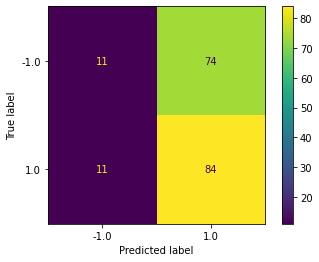

In [169]:
plot_confusion_matrix(clf, X_test_pca, y_test_bin)

In [170]:
y_pred = clf.predict(X_test_pca)

In [171]:
print('F1 score: '+str(f1_score(y_test_bin, y_pred, average='micro')))

F1 score: 0.5277777777777778


In [173]:
np.unique(y_test_bin, return_counts=True)

(array([-1.,  1.]), array([85, 95], dtype=int64))

# Autoencoder

In [44]:
import keras
from keras import layers
from keras.optimizers import Adam

In [111]:
# Simplest Autoencoder - This did not perform well. The loss remained the same at each epoch
# encoding_dim = 255
# input_img = keras.Input(shape=(54,43,))
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# decoded = layers.Dense(2322, activation='sigmoid')(encoded)
# autoencoder = keras.Model(input_img, decoded)
# encoder = keras.Model(input_img, encoded)
# encoded_input = keras.Input(shape=(encoding_dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
# customAdam = Adam(lr=0.001)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [144]:
# Convolutional Encoder
input_img = keras.Input(shape=(54,43,1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = layers.ZeroPadding2D(padding=((0,2),(0,5)))(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)

# at this point the representation is (7,6,8) i.e. 336-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Cropping2D(cropping=((0,2),(0,5)))(x)
print(x.shape)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)

(None, 54, 43, 16)
(None, 56, 48, 16)
(None, 28, 24, 16)
(None, 28, 24, 8)
(None, 14, 12, 8)
(None, 14, 12, 8)
(None, 7, 6, 8)
(None, 7, 6, 8)
(None, 14, 12, 8)
(None, 14, 12, 8)
(None, 28, 24, 8)
(None, 28, 24, 16)
(None, 56, 48, 16)
(None, 54, 43, 16)
(None, 54, 43, 1)


In [145]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## Preprocessing

In [107]:
# For convolutional autoencoder
X_train_temp_auto = X_train[:,0:2322].reshape((720,54,43))
X_train_press_auto = X_train[:,2322:4645].reshape((720,54,43))
X_test_temp_auto = X_test[:,0:2322].reshape((180,54,43))
X_test_press_auto = X_test[:,2322:4645].reshape((180,54,43))

## Train the Autoencoder

In [146]:
autoencoder.fit(X_train_temp_auto, X_train_temp_auto, epochs=50, batch_size=50, shuffle=False, validation_data=(X_test_temp_auto, X_test_temp_auto))

Epoch 1/50
144/144 [==============================] - 3s 18ms/step - loss: -3.2998 - val_loss: -5.0637
Epoch 2/50
144/144 [==============================] - 2s 17ms/step - loss: -5.4639 - val_loss: -5.8029
Epoch 3/50
144/144 [==============================] - 2s 17ms/step - loss: -5.8336 - val_loss: -5.9657
Epoch 4/50
144/144 [==============================] - 2s 17ms/step - loss: -5.9879 - val_loss: -6.1371
Epoch 5/50
144/144 [==============================] - 3s 17ms/step - loss: -6.0777 - val_loss: -6.2137
Epoch 6/50
144/144 [==============================] - 3s 18ms/step - loss: -6.1347 - val_loss: -6.2608
Epoch 7/50
144/144 [==============================] - 3s 18ms/step - loss: -6.1768 - val_loss: -6.2943
Epoch 8/50
144/144 [==============================] - 3s 19ms/step - loss: -6.2130 - val_loss: -6.3225
Epoch 9/50
144/144 [==============================] - 3s 19ms/step - loss: -6.2403 - val_loss: -6.3452
Epoch 10/50
144/144 [==============================] - 3s 21ms/step - los

In [153]:
X_train_autoencoder = autoencoder.predict(X_train_temp_auto)
mse = ((X_train_temp_auto-X_train_autoencoder.reshape((720,54,43)))**2).mean()
print(mse)


0.6161989964222553


#### This MSE is far worse than that of the PCA transform

# Try XGBoost

In [179]:
import xgboost as xgb

In [187]:
y_train_bin_xg = Binarizer().fit_transform(y_train)
y_test_bin_xg = Binarizer().fit_transform(y_test)
dtrain = xgb.DMatrix(X_train_pca, label=y_train_bin_xg)
dtest = xgb.DMatrix(X_test_pca, label=y_test_bin_xg)

In [190]:
param = {'max_depth':100, 'eta':1, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'
evallist = [(dtest,'eval'),(dtrain,'train')]
num_round = 20

In [191]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.53034	train-auc:0.98510
[1]	eval-auc:0.54180	train-auc:0.99996
[2]	eval-auc:0.51548	train-auc:1.00000
[3]	eval-auc:0.52855	train-auc:1.00000
[4]	eval-auc:0.53201	train-auc:1.00000
[5]	eval-auc:0.53300	train-auc:1.00000
[6]	eval-auc:0.54229	train-auc:1.00000
[7]	eval-auc:0.54341	train-auc:1.00000
[8]	eval-auc:0.55492	train-auc:1.00000
[9]	eval-auc:0.54985	train-auc:1.00000
[10]	eval-auc:0.54774	train-auc:1.00000
[11]	eval-auc:0.54539	train-auc:1.00000
[12]	eval-auc:0.55071	train-auc:1.00000
[13]	eval-auc:0.54724	train-auc:1.00000
[14]	eval-auc:0.55517	train-auc:1.00000
[15]	eval-auc:0.55059	train-auc:1.00000
[16]	eval-auc:0.54737	train-auc:1.00000
[17]	eval-auc:0.55368	train-auc:1.00000
[18]	eval-auc:0.54997	train-auc:1.00000
[19]	eval-auc:0.55084	train-auc:1.00000


In [197]:
y_pred = bst.predict(xgb.DMatrix(X_test_pca))
y_pred_bin = y_pred>=0.5

In [201]:
print('F1 score: '+str(f1_score(y_test_bin_xg, y_pred_bin, average='micro')))

F1 score: 0.5444444444444444


# Old Code

In [394]:
# Try some oversampling to combat the class imbalance
x_resampled, y_resampled = SMOTE().fit_resample(X_train_pca, y_train)
print(sorted(Counter(y_resampled).items()))

#x_resampled, y_resampled = RandomOverSampler().fit_resample(X_train_pca, y_train)
#print(sorted(Counter(y_resampled).items()))

[(-1.0, 625), (0.0, 625), (1.0, 625)]


In [395]:
#rf = RandomForestClassifier(random_state=1337)
rf = RandomForestClassifier(random_state=1337, criterion='entropy', max_depth=10, min_samples_split=15)
#ad = AdaBoostClassifier(random_state=1337)

In [396]:
#train best model
clf = rf.fit(x_resampled, y_resampled)

In [387]:
# HPO
## Random Forest ##
# parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
# clf = GridSearchCV(rf, parameters)
# #clf.fit(X_train_pca, y_train_cat)
# #clf.fit(X_train,y_train_bin)
# clf.fit(x_resampled, y_resampled)
# print(clf.best_score_)
# print(clf.best_params_)

## AdaBoost ##
# parameters = {'n_estimators':[50, 100], 'learning_rate':[0.1, 1, 5]}
# clf = GridSearchCV(ad, parameters)
# #clf.fit(X_train_pca, y_train_bin)
# clf.fit(X_train_autoencoder, y_train_cat)

In [ ]:
# Transform target to 3 categories
# med_ids = np.where(np.logical_and(-1.5<y, y<1.5))[0]
# y[y>=1.5] = 1 
# y[y<=-1.5] = -1
# y[med_ids] = 0
# X = np.concatenate((X_tas,X_psl),axis=1)
# y=y.reshape(-1,1)